In [1]:
import pandas as pd

In [2]:
client = pd.read_csv("../data/client.csv")
ePrices = pd.read_csv("../data/electricity_prices.csv")
gasPrices = pd.read_csv("../data/gas_prices.csv")

weatherPredInt = pd.read_csv("interpolPredWeather.csv")
#weatherHist = pd.read_csv("../data/historical_weather.csv")
train = pd.read_csv("../data/train.csv")

## combine data

In [3]:
producing = train.loc[train.is_consumption == 0]
consuming = train.loc[train.is_consumption == 1]
train = pd.merge(producing.drop('is_consumption',axis = 1), consuming.drop('is_consumption',axis = 1),on=['data_block_id','prediction_unit_id','datetime','county','is_business','product_type'], how='outer',suffixes=('_prod', '_cons'))
del producing, consuming
print(train.shape)

(1009176, 10)


In [4]:
df_prices = pd.merge(ePrices, gasPrices[['data_block_id','lowest_price_per_mwh','highest_price_per_mwh']], on=['data_block_id'], how='outer',suffixes=('_el', '_gas'))

In [5]:
df_prices['datetime'] = pd.to_datetime(df_prices['forecast_date'])
train['datetime'] = pd.to_datetime(train['datetime'])

In [6]:
df = pd.merge(train, df_prices,on=['datetime'], how='outer',suffixes=('', '_GasEl_prices'))
del df_prices

In [7]:
weatherPredInt['datetime'] = pd.to_datetime(weatherPredInt['forecast_datetime'])
weatherPredInt = weatherPredInt.rename(columns={'County': 'county'})

In [8]:
weatherPredInt['hour'] = weatherPredInt['datetime'].dt.hour
df['hour'] = df['datetime'].dt.hour

In [9]:
df = pd.merge(df, weatherPredInt, on=['hour','county','data_block_id'], how='inner')
df.shape

(1007712, 36)

In [11]:
# merge with clients
df = pd.merge(df, client, on=['county','is_business','product_type','data_block_id'], how='outer')
df.shape

(1007762, 39)

In [26]:
df.datetime_x

Index(['county', 'is_business', 'product_type', 'target_prod', 'datetime_x',
       'data_block_id', 'row_id_prod', 'prediction_unit_id', 'target_cons',
       'row_id_cons', 'forecast_date', 'euros_per_mwh', 'origin_date',
       'data_block_id_GasEl_prices', 'lowest_price_per_mwh',
       'highest_price_per_mwh', 'hour', 'Unnamed: 0', 'latitude', 'longitude',
       'forecast_datetime', 'hours_ahead', 'origin_datetime', 'temperatureint',
       'dewpointint', 'cloudcover_highint', 'cloudcover_lowint',
       'cloudcover_midint', 'cloudcover_totalint',
       '10_metre_u_wind_componentint', '10_metre_v_wind_componentint',
       'direct_solar_radiationint', 'surface_solar_radiation_downwardsint',
       'snowfallint', 'total_precipitationint', 'datetime_y', 'eic_count',
       'installed_capacity', 'date'],
      dtype='object')

In [31]:
df['yearday'] = df['datetime_x'].dt.day_of_year
df['weekday'] = df['datetime_x'].dt.day_of_week
df['month'] = df['datetime_x'].dt.month

/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_19615/2415486271.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['yearday'] = df['datetime_x'].dt.day_of_year
/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_19615/2415486271.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weekday'] = df['datetime_x'].dt.day_of_week
/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_19615/2415486271.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [16]:
df = df.dropna()

# check correlations

<AxesSubplot:>

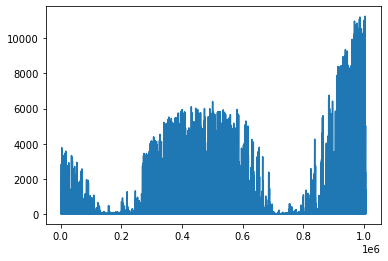

In [17]:
df.loc[df.is_business == 0].target_prod.plot()

In [36]:
corr_matrix = df.corr()
correlations_prod = corr_matrix['target_prod'].sort_values(ascending=False)
correlations_cons = corr_matrix['target_cons'].sort_values(ascending=False)

In [37]:
correlations_prod

target_prod                             1.000000
surface_solar_radiation_downwardsint    0.389365
installed_capacity                      0.356369
direct_solar_radiationint               0.347997
eic_count                               0.339173
temperatureint                          0.228567
product_type                            0.135231
target_cons                             0.108288
dewpointint                             0.093339
data_block_id                           0.086451
data_block_id_GasEl_prices              0.086451
row_id_prod                             0.086179
row_id_cons                             0.086179
latitude                                0.058681
hours_ahead                             0.041061
hour                                    0.041061
weekday                                 0.022774
10_metre_u_wind_componentint            0.021961
lowest_price_per_mwh                    0.015229
highest_price_per_mwh                   0.009609
longitude           

In [38]:
correlations_cons

target_cons                             1.000000
installed_capacity                      0.809344
eic_count                               0.336634
is_business                             0.255040
product_type                            0.222207
latitude                                0.156535
target_prod                             0.108288
cloudcover_lowint                       0.055214
cloudcover_totalint                     0.043321
row_id_prod                             0.029740
row_id_cons                             0.029740
data_block_id                           0.029573
data_block_id_GasEl_prices              0.029573
cloudcover_midint                       0.026179
euros_per_mwh                           0.025790
snowfallint                             0.021607
cloudcover_highint                      0.016053
10_metre_v_wind_componentint            0.014429
hour                                    0.013663
hours_ahead                             0.013663
total_precipitationi

<AxesSubplot:>

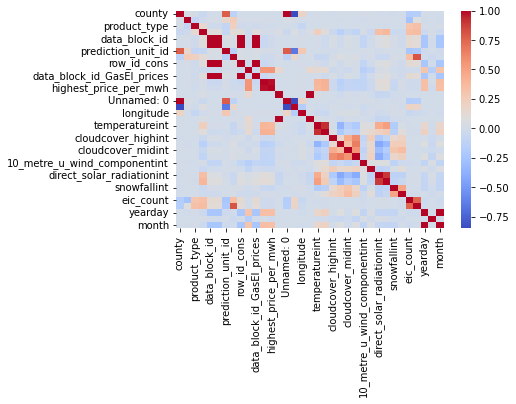

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(corr_matrix, cmap="coolwarm")
#plt.show()

# try to fit a little tree

In [41]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

In [44]:
Y = df[['target_prod','target_cons']]
X = df.drop(['target_prod','target_cons', 'datetime_x',
       'row_id_cons', 'forecast_date', 'origin_date',
       'Unnamed: 0',
       'forecast_datetime', 'hours_ahead', 'origin_datetime', 'datetime_y', 'date'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42, shuffle = False)

In [51]:
y_train.target_cons

1464       0.793
1465       2.106
1466       0.955
1467       0.711
1468       0.729
           ...  
604067    63.683
604068    55.180
604069    50.340
604070    58.049
604071    61.917
Name: target_prod, Length: 601739, dtype: float64

In [52]:
random_forest_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
random_forest_model.fit(X_train, y_train.target_prod)

ValueError: continuous is not supported

In [54]:
random_forest_test_predictions = random_forest_model.predict(X_train)
random_forest_test_accuracy = sum(abs(y_train.target_prod - random_forest_test_predictions))/len(y_train)
print("Random Forest train Accuracy:", random_forest_test_accuracy)

# Make predictions on the testing set using the trained model
random_forest_test_predictions = random_forest_model.predict(X_test)

# Calculate accuracy of the random forest model on the testing set
random_forest_test_accuracy = sum(abs(y_test.target_prod- random_forest_test_predictions))/len(y_test)
print("Random Forest Test Accuracy:", random_forest_test_accuracy)

Random Forest train Accuracy: 26.07718183200533
Random Forest Test Accuracy: 43.93698269424609


In [55]:
print(random_forest_test_predictions[0:20])
print(y_test.target_prod.to_numpy()[0:20])

[ 16.6031463    5.84723095   0.89005171   0.88896512   0.76900953
   0.76379282   0.76379282   0.7359595    0.26925229   0.26925229
   0.26925229   0.26925229   0.26925229   0.56286539   1.32390281
  10.68224417  60.86747416  71.44241514 234.2327413  218.67328976]
[4.58090e+01 1.90300e+01 5.11700e+00 1.25000e-01 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 1.21900e+00 5.64000e-01 4.70000e-01 7.56000e-01
 6.13000e-01 8.60000e-02 5.00000e-03 8.18000e-01 1.12830e+01 5.91650e+01
 1.59393e+02 2.37765e+02]


In [ ]:
random_forest_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
random_forest_model.fit(X_train, y_train.target_cons)
random_forest_test_predictions = random_forest_model.predict(X_train)
random_forest_test_accuracy = balanced_accuracy_score(y_train.target_cons, random_forest_test_predictions)
print("Random Forest train Accuracy:", random_forest_test_accuracy)

# Make predictions on the testing set using the trained model
random_forest_test_predictions = random_forest_model.predict(X_test)

# Calculate accuracy of the random forest model on the testing set
random_forest_test_accuracy = balanced_accuracy_score(y_test.target_cons, random_forest_test_predictions)
print("Random Forest Test Accuracy:", random_forest_test_accuracy)
print(random_forest_test_predictions)
#print(y_test.target_cons.to_numpy())

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
scaler2 = MinMaxScaler()
Y_normalized = scaler2.fit_transform(Y)


X_trainN, X_testN, y_trainN, y_testN = train_test_split(X_normalized, Y_normalized, test_size=0.4, random_state=42, shuffle = False)

random_forest_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
random_forest_model.fit(X_trainN, y_trainN)
random_forest_test_predictions = random_forest_model.predict(X_trainN)
random_forest_test_accuracy = balanced_accuracy_score(y_trainN, random_forest_test_predictions)
print("Random Forest train Accuracy:", random_forest_test_accuracy)

# Make predictions on the testing set using the trained model
random_forest_test_predictions = random_forest_model.predict(X_testN)

# Calculate accuracy of the random forest model on the testing set
random_forest_test_accuracy = balanced_accuracy_score(y_testN, random_forest_test_predictions)
print("Random Forest Test Accuracy:", random_forest_test_accuracy)
print(random_forest_test_predictions)
print(y_testN.to_numpy())
